#Imports

In [93]:
!wget -O Admission_Predict_A3.csv "https://drive.google.com/uc?export=download&id=1pYyHwVWPCrCyI6J8iJ5CHEzpeCLUMQwE"

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
os.environ['TF_USE_LEGACY_KERAS'] = '1'

--2024-10-20 21:08:03--  https://drive.google.com/uc?export=download&id=1pYyHwVWPCrCyI6J8iJ5CHEzpeCLUMQwE
Resolving drive.google.com (drive.google.com)... 173.194.215.101, 173.194.215.100, 173.194.215.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pYyHwVWPCrCyI6J8iJ5CHEzpeCLUMQwE&export=download [following]
--2024-10-20 21:08:03--  https://drive.usercontent.google.com/download?id=1pYyHwVWPCrCyI6J8iJ5CHEzpeCLUMQwE&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16178 (16K) [application/octet-stream]
Saving to: ‘Admission_Predict_A3.csv’

Admission_Predict_A 100%[===================>]  15.

#Data Loading, Preparation and Scaling


In [94]:
# Setting up the data and cleaning it
data_with_sr_no = pd.read_csv('Admission_Predict_A3.csv')
data_unedited = data_with_sr_no.drop(columns =['Serial No.'])
rows_columns = data_unedited.shape

print("The number of rows and columns is: ")
print(rows_columns)
print(data_unedited.dtypes)
print(data_unedited.describe())

missing_values = data_unedited.isna().sum()
print("\nThe missing vaues are: ")
print(missing_values)

data_duplicates_deleted = data_unedited.drop_duplicates()
rows_columns_1 = data_duplicates_deleted.shape
print("\nThe number of rows and columns after deletion of duplicates is: ")
print(rows_columns_1)
print("\nThus we have no missing values or duplicates and can proceed with scaling.")

z_scores = np.abs(stats.zscore(data_unedited))
outliers = np.where(z_scores >2.5)
print("\nThe outliers are: ")
print(outliers)

#Since we have some outliers present,
#we will use RobustScaler to scale the data.
#It scales features using statistics that are robust to outliers.
#This method removes the median and scales the data in the range between 1st quartile and 3rd quartile.
#i.e., in between 25th quantile and 75th quantile range.

numerical_features = data_duplicates_deleted.select_dtypes(include=['float64', 'int64']).columns
robust_scaler = RobustScaler()
data_robust_scaled = data_duplicates_deleted.copy()
data_robust_scaled[numerical_features] = robust_scaler.fit_transform(data_duplicates_deleted[numerical_features])

print("\nRobust Scaled Data (first few rows):\n",data_robust_scaled.head())
print("\nOriginal Data Range:")
print(data_duplicates_deleted[numerical_features].agg(['min', 'max']))
print("\nRobustScaler Data Range:")
print(data_robust_scaled[numerical_features].agg(['min', 'max']))
print("\nThe RobustScaled dataframe is as follows: ")
print(data_robust_scaled.describe())

The number of rows and columns is: 
(500, 8)
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object
        GRE Score  TOEFL Score  University Rating         SOP       LOR   \
count  500.000000   500.000000         500.000000  500.000000  500.00000   
mean   316.472000   107.192000           3.114000    3.374000    3.48400   
std     11.295148     6.081868           1.143512    0.991004    0.92545   
min    290.000000    92.000000           1.000000    1.000000    1.00000   
25%    308.000000   103.000000           2.000000    2.500000    3.00000   
50%    317.000000   107.000000           3.000000    3.500000    3.50000   
75%    325.000000   112.000000           4.000000    4.000000    4.00000   
max    340.000000   120.000000           5.000000    5.000000    5.00000   

             CGPA    Res

#Dimensionality Reduction with LDA

     GRE Score  TOEFL Score  University Rating       SOP  LOR       CGPA  \
0     1.176471     1.222222                0.5  0.666667   1.0  1.194521   
1     0.411765     0.000000                0.5  0.333333   1.0  0.339726   
2    -0.058824    -0.333333                0.0 -0.333333   0.0 -0.613699   
3     0.294118     0.333333                0.0  0.000000  -1.0  0.120548   
4    -0.176471    -0.444444               -0.5 -1.000000  -0.5 -0.383562   
..         ...          ...                ...       ...   ...       ...   
495   0.882353     0.111111                1.0  0.666667   0.5  0.504110   
496   1.176471     1.111111                1.0  1.000000   1.5  1.435616   
497   0.764706     1.444444                1.0  0.666667   1.5  1.095890   
498  -0.294118    -0.444444                0.5  0.333333   1.5 -0.142466   
499   0.588235     0.666667                0.5  0.666667   1.0  0.526027   

     Research Chance of Admit Binned  
0         0.0                   High  
1        

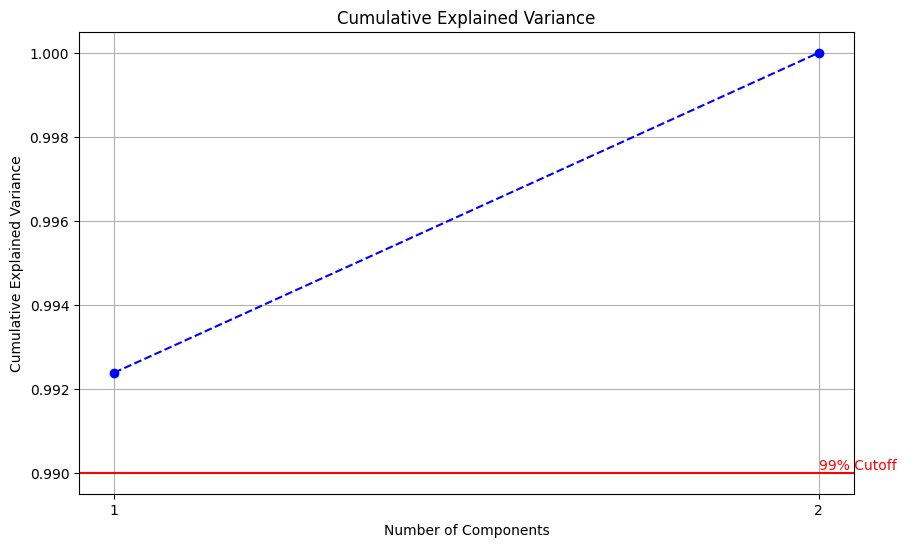


Thus we will only retain the first component to simplify our model and avoid overfitting.

The size of the final training data is: 
400

The size of the final testing data is: 
100

The final training array after applying LDA is: 
[[ 0.38461103]
 [ 2.73651918]
 [ 1.06414041]
 [ 0.59316889]
 [-0.12736056]
 [-0.94491752]
 [ 1.6468001 ]
 [-1.44868021]
 [-1.58384983]
 [-1.184273  ]
 [-0.15997001]
 [ 2.22293629]
 [-0.86885718]
 [ 2.07768792]
 [ 4.01211888]] [0.99238262 0.00761738]

The final testing array after applying LDA is: 
[[ 0.03436152]
 [-3.37635874]
 [-1.98308277]
 [ 0.31766231]
 [-3.21259709]
 [ 0.11535685]
 [ 1.70203216]
 [ 0.10863087]
 [-2.85729074]
 [ 0.50595826]
 [-2.21916223]
 [-1.09209274]
 [-0.51244289]
 [-1.44252959]
 [-3.14530619]] [0.99238262 0.00761738]


In [95]:
#Converting "Chance of Admit" into a Categorical Variable

data_robust_scaled['Chance of Admit Binned'] = pd.cut(data_robust_scaled['Chance of Admit '], bins=3, labels=['Low', 'Medium', 'High'], include_lowest=True)
data_scaled_binned = data_robust_scaled.drop('Chance of Admit ',axis=1)
data_scaled_notbinned = data_robust_scaled.drop('Chance of Admit Binned', axis=1)
print(data_scaled_binned)

#Performing LDA on the dataframe wrt the categorical variable

X_binned = data_scaled_binned.drop('Chance of Admit Binned',axis=1)
y_binned = data_scaled_binned['Chance of Admit Binned']

X_train_binned, X_test_binned, y_train_binned, y_test_binned = train_test_split(X_binned, y_binned, train_size=0.8, random_state=69)

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_binned, y_train_binned)
X_test_lda = lda.transform(X_test_binned)
print("\nThe size of the training array after applying LDA is: ")
print(X_train_lda.size)
print("\nThe size of the testing array after applying LDA is: ")
print(X_test_lda.size)


lda_variance_ratio = lda.explained_variance_ratio_
print("\nThe training array after applying LDA is: ")
print(X_train_lda[:5], lda_variance_ratio)
print("\nThe testing array after applying LDA is: ")
print(X_test_lda[:5], lda_variance_ratio)

print("\nThe number of components after applying LDA reduces to 2, because we had 3 features to begin with.")
print("\nCalculating the Explained Variance we find that Component1 explains 99.23% percent of the variance,")
print("\nwhereas Component2 only explains 0.07% of the variance, adding very little additional seperability.")

cumulative_variance = np.cumsum(lda_variance_ratio)
# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid()
plt.axhline(y=0.99, color='r', linestyle='-')  # Example for 99% threshold
plt.text(len(cumulative_variance), 0.99, '99% Cutoff', color='red', verticalalignment='bottom')
plt.show()

print("\nThus we will only retain the first component to simplify our model and avoid overfitting.")
lda_final = LDA(n_components = 1)
X_train_lda_final = lda_final.fit_transform(X_train_binned, y_train_binned)
X_test_lda_final = lda_final.transform(X_test_binned)
print("\nThe size of the final training data is: ")
print(X_train_lda_final.size)
print("\nThe size of the final testing data is: ")
print(X_test_lda_final.size)
print("\nThe final training array after applying LDA is: ")
print(X_train_lda_final[:15], lda_variance_ratio)
print("\nThe final testing array after applying LDA is: ")
print(X_test_lda_final[:15], lda_variance_ratio)


#Linear Regression on LDA Transformed Data

##Using TensorFlow

In [96]:
# Define the linear regression function
def linear_regression_tensorflow(X, w, b):
  return tf.matmul(X, w) + b

# Define the Mean Squared Error (MSE) loss function
def compute_loss_tensorflow(y_true, y_pred, w = None, l2_strength = 0):
  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  if l2_strength != 0:
    mse += (l2_strength * tf.nn.l2_loss(w))
  return mse

def train_tensorflow(x_data, y_data, rate, iterations, l2_strength = 0, plot = True):
  X_train_tensor = tf.convert_to_tensor(x_data, dtype=tf.float32)
  y_train_tensor = tf.convert_to_tensor(y_data, dtype=tf.float32)

  # Initialize the model parameters (weights and bias)
  weights = tf.Variable(tf.zeros([1, 1]), dtype=tf.float32)
  bias = tf.Variable(tf.zeros([1]), dtype=tf.float32)

  # Set up the SGD optimizer
  optimizer = tf.keras.optimizers.SGD(learning_rate=rate)

  # Training loop
  epochs = iterations
  losses = []
  for epoch in range(epochs):
      with tf.GradientTape() as tape:
        # Compute predictions and loss
        predictions = linear_regression_tensorflow(X_train_tensor, weights, bias)
        loss = compute_loss_tensorflow(y_train_tensor, predictions, weights, l2_strength)

        # Compute gradients
        gradients = tape.gradient(loss, [weights, bias])

        # Update parameters using SGD
        optimizer.apply_gradients(zip(gradients, [weights, bias]))

        losses.append(loss.numpy())

  # Plot Learning Curve
  if plot:

    # Final trained weights and bias and loss
    print("Trained weights: ", weights.numpy())
    print("Trained bias: ", bias.numpy())

    epochs = range(1, len(losses)+1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs,losses)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Learning Curve')
    plt.show()

  return [weights, bias, losses]

def test_tensorflow(x_data, y_data, model, plot = True):
  weights = model[0]
  bias = model[1]

  # Convert test data to TensorFlow tensors
  X_test_tensor = tf.convert_to_tensor(x_data, dtype=tf.float32)
  y_test_tensor = tf.convert_to_tensor(y_data, dtype=tf.float32)

  # Make predictions on the test set using the trained weights and bias
  predictions_test = linear_regression_tensorflow(X_test_tensor, weights, bias)

  # Print final loss
  err = compute_loss_tensorflow(y_data, predictions_test).numpy()

  # Convert TensorFlow tensors to NumPy arrays for easier plotting
  predictions_test_np = predictions_test.numpy()
  y_test_np = y_test_tensor.numpy()

  # Plot predicted vs actual values
  if plot:
    print("The MSE is: ", err)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_np, predictions_test_np, color='blue', label='Predicted vs True')
    plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', label='Perfect Prediction Line')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Results')
    plt.legend()
    plt.show()

  return [predictions_test_np, err]

Trained weights:  [[-0.38281184]]
Trained bias:  [-0.01118419]


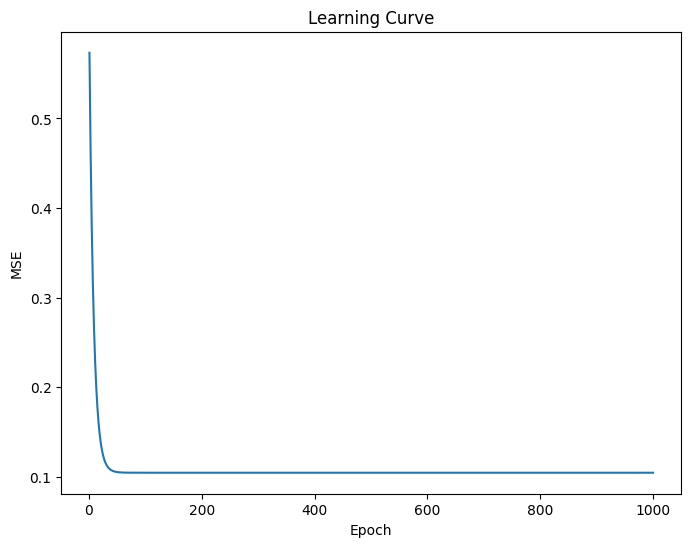

The MSE is:  0.07547153


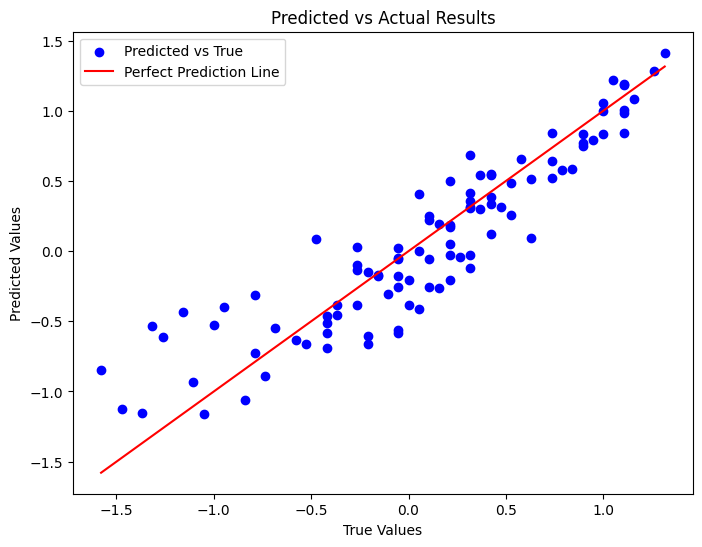

In [97]:
# Getting Data

x = data_scaled_notbinned.drop('Chance of Admit ',axis=1)
y = data_scaled_notbinned['Chance of Admit ']

_, _, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=69)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
x_train = X_train_lda_final
x_test = X_test_lda_final

# Running the model
t_model = train_tensorflow(x_train, y_train, 0.01, 1000)
err_tensorflow = t_model[2][-1]
_ = test_tensorflow(x_test, y_test, t_model)

##Using SciKit

In [98]:
def train_sklearn(x_data, y_data):
  model = LinearRegression()

  # Train the model
  model.fit(x_data, y_data)
  return model

def test_sklearn(model, x_data, y_data):
  # Make prediction
  y_test_pred = model.predict(x_data)
  print("The MSE is: ", mean_squared_error(y_data, y_test_pred))

  # Plot test data
  plt.figure(figsize=(8, 6))
  plt.scatter(y_data, y_test_pred, color='green', label='Predicted vs True')
  plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], color='red', label='Perfect Prediction Line')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('Performance')
  plt.legend()
  plt.show()

The MSE is:  0.07547153172748176


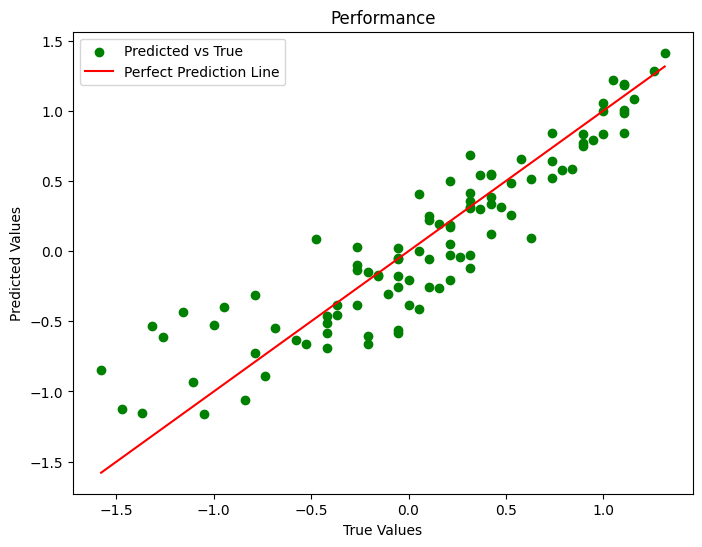

In [99]:
s_model = train_sklearn(x_train, y_train)
test_sklearn(s_model, x_test, y_test)

#Logistic Regression

In [100]:
#Our dataframe with the target variable binned into 3 categories is:
print(data_scaled_binned)
#We've already split the data into test and train.
#and we have already applied LDA on the feature variables wrt the Target variable
#and achieved dimensionality reduction. We will use the reduced dimension data
#for our logistic regression model.

# Convert target labels to one-hot encoding for multi-class classification
y_train_binned_encoded = pd.get_dummies(y_train_binned).values
y_test_binned_encoded = pd.get_dummies(y_test_binned).values

model_logistic = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_lda_final.shape[1],)),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_logistic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Start with learning rate 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_logistic.fit(X_train_lda_final,y_train_binned_encoded, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model_logistic.evaluate(X_test_lda_final, y_test_binned_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Make predictions on the test data
y_pred_logistic = model_logistic.predict(X_test_lda_final)

# Convert one-hot encoded predictions and true labels back to class labels
y_pred_classes = np.argmax(y_pred_logistic, axis=1)
y_true_classes = np.argmax(y_test_binned_encoded, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Prediction Accuracy: {accuracy}")

f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1 Score: {f1}")

#Varying the learning rates
learning_rates = [0.001, 0.01, 0.1, 0.0001]
best_accuracy = 0
best_lr = None

for lr in learning_rates:
    print(f"\nTraining model with learning rate: {lr}")
    # Rebuild and compile the model with the new learning rate
    model_logistic = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_lda_final.shape[1],)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model_logistic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model_logistic.fit(X_train_lda_final, y_train_binned_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    test_loss, test_accuracy = model_logistic.evaluate(X_test_lda_final, y_test_binned_encoded, verbose=0)
    print(f"Test Accuracy for learning rate {lr}: {test_accuracy}")

    # Track the best performing learning rate
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_lr = lr

print(f"\nBest Learning Rate: {best_lr}, Best Test Accuracy: {best_accuracy}")

#Model Evaluation Characteristics

#1) Accuracy
print("\nThe best accuracy and learning rate is: ")
print(f"Best Learning Rate: {best_lr}, Best Test Accuracy: {best_accuracy}")

#2)Precision
print("\nThe precision is: ")
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f'Precision: {precision}')

#3)Recall
print("\nThe recall is: ")
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f'Recall: {recall}')

#4)F1 Score
print("\nThe F1 score is: ")
print(f"F1 Score: {f1}")

#5)AUC ROC
print("\nThe AUC-ROC is: ")
y_prob = model_logistic.predict(X_test_lda_final)
auc_roc = roc_auc_score(y_true_classes, y_prob, multi_class='ovr')
print(f'Multiclass AUC-ROC: {auc_roc}')

     GRE Score  TOEFL Score  University Rating       SOP  LOR       CGPA  \
0     1.176471     1.222222                0.5  0.666667   1.0  1.194521   
1     0.411765     0.000000                0.5  0.333333   1.0  0.339726   
2    -0.058824    -0.333333                0.0 -0.333333   0.0 -0.613699   
3     0.294118     0.333333                0.0  0.000000  -1.0  0.120548   
4    -0.176471    -0.444444               -0.5 -1.000000  -0.5 -0.383562   
..         ...          ...                ...       ...   ...       ...   
495   0.882353     0.111111                1.0  0.666667   0.5  0.504110   
496   1.176471     1.111111                1.0  1.000000   1.5  1.435616   
497   0.764706     1.444444                1.0  0.666667   1.5  1.095890   
498  -0.294118    -0.444444                0.5  0.333333   1.5 -0.142466   
499   0.588235     0.666667                0.5  0.666667   1.0  0.526027   

     Research Chance of Admit Binned  
0         0.0                   High  
1        

#Hyperparameter Tuning


## Different Learning Rates

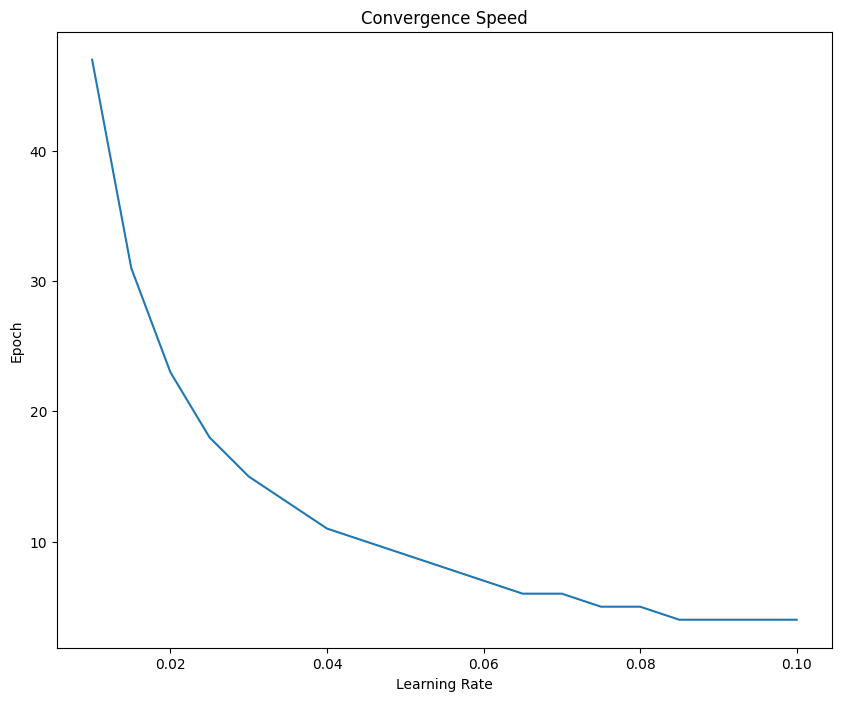

In [101]:
learning_rates = [i/1000 for i in range(10,101,5)]
threshold = err_tensorflow
iterations = 100

req_epochs = []
for i in learning_rates:
  m = train_tensorflow(x_train, y_train, i, iterations, plot = False)
  for j in range(iterations):
    if abs(m[2][j]-threshold) <= 0.001:
      req_epochs.append(j)
      break

plt.figure(figsize=(10, 8))
plt.plot(learning_rates, req_epochs)
plt.xlabel('Learning Rate')
plt.ylabel('Epoch')
plt.title('Convergence Speed')
plt.show()

In [102]:
#b)Logistic Regression
learning_rates = [0.001, 0.01, 0.1, 0.0001]
best_accuracy = 0
best_lr = None

for lr in learning_rates:
    print(f"\nTraining model with learning rate: {lr}")
    # Rebuild and compile the model with the new learning rate
    model_logistic = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_lda_final.shape[1],)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model_logistic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model_logistic.fit(X_train_lda_final, y_train_binned_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    test_loss, test_accuracy = model_logistic.evaluate(X_test_lda_final, y_test_binned_encoded, verbose=0)
    print(f"Test Accuracy for learning rate {lr}: {test_accuracy}")

    # Track the best performing learning rate
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_lr = lr

print(f"\nBest Learning Rate: {best_lr}, Best Test Accuracy: {best_accuracy}")


Training model with learning rate: 0.001
Test Accuracy for learning rate 0.001: 0.7799999713897705

Training model with learning rate: 0.01
Test Accuracy for learning rate 0.01: 0.800000011920929

Training model with learning rate: 0.1
Test Accuracy for learning rate 0.1: 0.8100000023841858

Training model with learning rate: 0.0001
Test Accuracy for learning rate 0.0001: 0.12999999523162842

Best Learning Rate: 0.1, Best Test Accuracy: 0.8100000023841858


##HyperParameter Tuning

###Grid Search

In [103]:
l2_values = [0, 1, 2, 3, 4]
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05]
iterations = 15

results = [[] for i in range(5)]

for i in range(5):
  for j in range(5):
    m = train_tensorflow(x_train,y_train,learning_rates[i],iterations,l2_values[j],False)
    results[i].append(test_tensorflow(x_test,y_test,m,False)[1])
print(np.array(results))

[[0.12989722 0.14117213 0.1524763  0.16367172 0.17465444]
 [0.08239711 0.09406226 0.10842566 0.12399706 0.13983442]
 [0.07622574 0.08558955 0.10046165 0.11751423 0.13496573]
 [0.07547598 0.08380461 0.09898529 0.1165761  0.13446726]
 [0.07539609 0.08345292 0.09878647 0.1165263  0.13450387]]


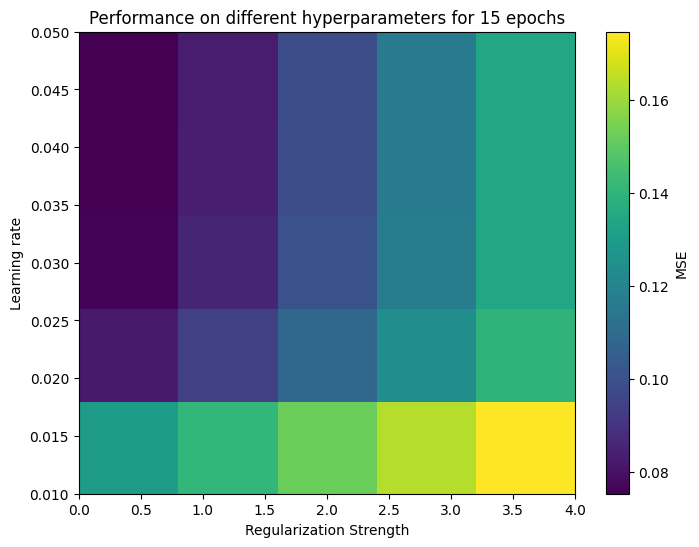

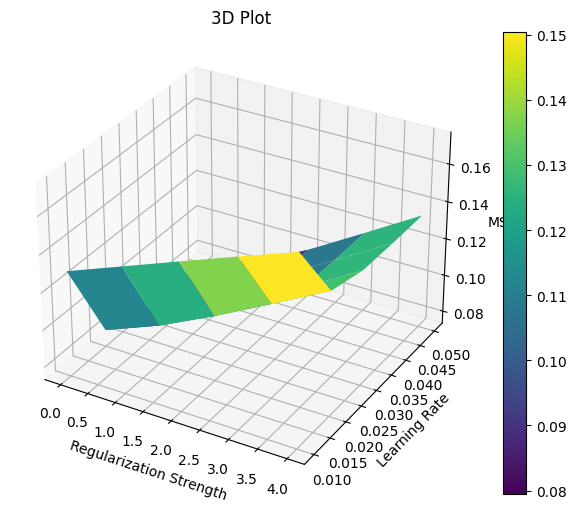

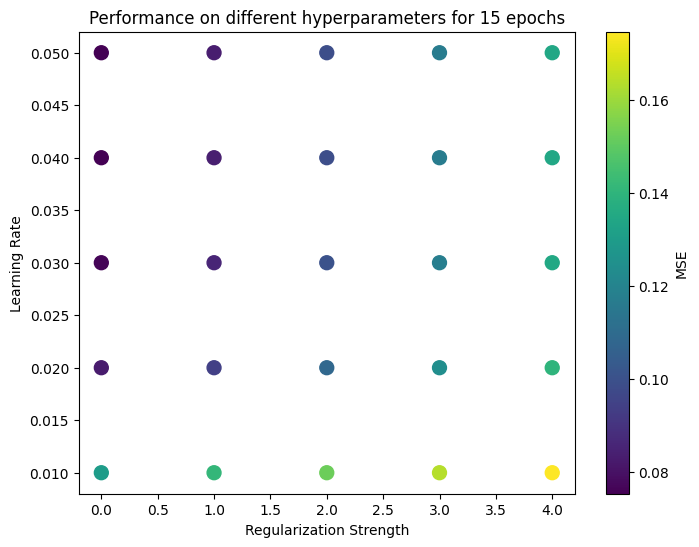

In [104]:
def plots():
  # Create meshgrid
  X_grid, Y_grid = np.meshgrid(l2_values, learning_rates)
  Z = np.array(results)

  # Create the heatmap
  plt.figure(figsize=(8, 6))
  plt.imshow(Z, aspect='auto', cmap='viridis', extent=[min(l2_values), max(l2_values), min(learning_rates), max(learning_rates)], origin='lower')

  # Add color bar to indicate value scale
  plt.colorbar(label='MSE')

  # Set labels and title
  plt.title(f'Performance on different hyperparameters for {iterations} epochs')
  plt.xlabel('Regularization Strength')
  plt.ylabel('Learning rate')

  plt.show()

  # Create the 3D plot
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the surface
  surf = ax.plot_surface(X_grid, Y_grid, Z, cmap='viridis')

  # Add labels
  ax.set_xlabel('Regularization Strength')
  ax.set_ylabel('Learning Rate')
  ax.set_zlabel('MSE')
  ax.set_title('3D Plot')

  # Add color bar to show scale
  fig.colorbar(surf)

  # Show the plot
  plt.show()

  # Flatten the arrays to pass into plt.scatter
  X_flat = X_grid.flatten()
  Y_flat = Y_grid.flatten()
  Z_flat = Z.flatten()  # Flatten the 2D Z array to match X and Y

  # Create the scatter plot
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(X_flat, Y_flat, c=Z_flat, cmap='viridis', s=100)

  # Add color bar to show the mapping of Z values
  plt.colorbar(scatter, label='MSE')

  # Add labels and title
  plt.title(f'Performance on different hyperparameters for {iterations} epochs')
  plt.xlabel('Regularization Strength')
  plt.ylabel('Learning Rate')

  # Show the plot
  plt.show()
plots()

###Random Search


In [106]:
l2_values = np.random.uniform(0.01, 5, 5)
learning_rates = np.random.uniform(0.0001, 0.1, 5)
iterations = 15

results = [[] for i in range(5)]

for i in range(5):
  for j in range(5):
    m = train_tensorflow(x_train,y_train,learning_rates[i],iterations,l2_values[j],False)
    results[i].append(test_tensorflow(x_test,y_test,m,False)[1])

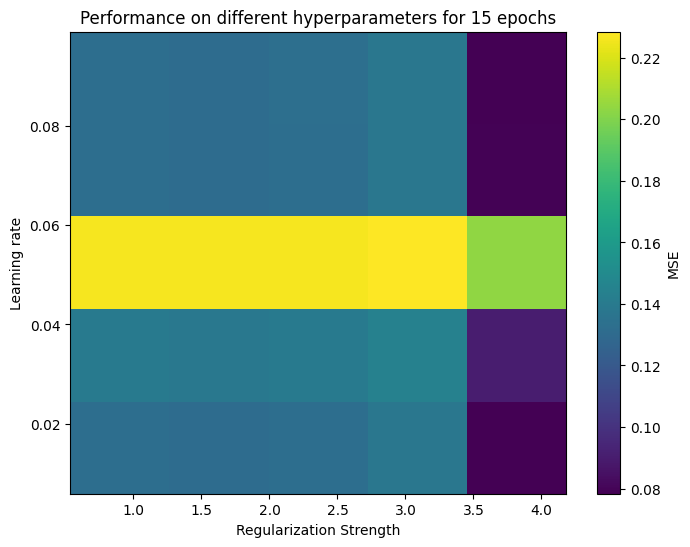

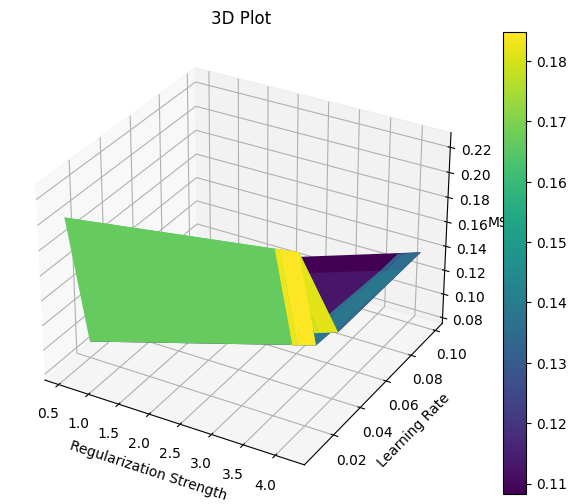

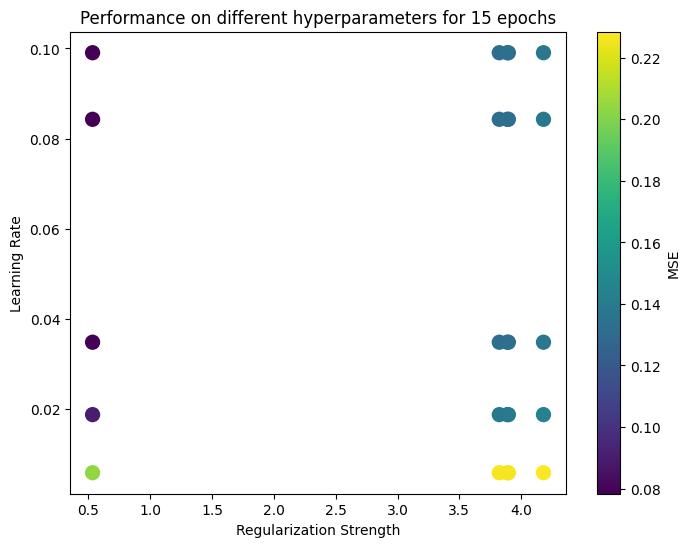

In [107]:
plots()

#Model Evaluation

In [105]:
#1) K Fold Cross Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

#a) For Linear Regression
model_linear = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=69)
results = cross_val_score(model_linear, x_train, y_train, cv=kf, scoring='r2')
print("\nThe cross-validation results are: ")
print(f"Cross-validation results for Linear Regression are: {results}")
print(f"Mean R2: {np.mean(results):.4f}")


#b) For Logistic Regression
# Perform K-fold cross-validation
model_logistic = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=69)
results = cross_val_score(model_logistic, X_train_lda_final, y_train_binned, cv=kf, scoring='accuracy')
print("\nThe cross-validation results are: ")
print(f"Cross-validation results for Logistic Regression are: {results}")
print(f"Mean Accuracy: {np.mean(results):.4f}")

#2) Metrics

#a) For Linear Regression
print("\nThe metrics for linear regression are: ")
print("MSE: ",test_tensorflow(x_test, y_test, t_model, plot=False)[1])
r2_model = s_model.score(x_test, y_test)
print("R2: ",r2_model)

#b) For Logistic Regression
print("\nThe metrics for logistic regression are: ")
print(f"Accuracy: {accuracy}")
print(f'Precision: {precision}')
print(f"F1 Score: {f1}")
print(f'Recall: {recall}')
print(f'Multiclass AUC-ROC: {auc_roc}')


The cross-validation results are: 
Cross-validation results for Linear Regression are: [0.83183569 0.87211876 0.75087105 0.80342357 0.82644303]
Mean R2: 0.8169

The cross-validation results are: 
Cross-validation results for Logistic Regression are: [0.825  0.8875 0.825  0.8    0.8375]
Mean Accuracy: 0.8350

The metrics for linear regression are: 
MSE:  0.07547153
R2:  0.8331600979193046

The metrics for logistic regression are: 
Accuracy: 0.8
Precision: 0.8102097902097901
F1 Score: 0.7908867450773093
Recall: 0.8
Multiclass AUC-ROC: 0.7122383443504132
